In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point
import folium

In [2]:
# !pip install osmnx geopandas folium geopy

In [14]:
df = pd.read_csv('data/CA_LA_subset.csv')
print(df.head())

        ID   Source  Severity           Start_Time             End_Time  \
0  A-42867  Source2         2  2016-06-21 10:46:30  2016-06-21 11:27:00   
1  A-42868  Source2         3  2016-06-21 10:49:21  2016-06-21 11:34:21   
2  A-42882  Source2         3  2016-06-21 10:51:45  2016-06-21 11:36:45   
3  A-42884  Source2         3  2016-06-21 10:56:24  2016-06-21 11:34:00   
4  A-42899  Source2         3  2016-06-21 11:30:46  2016-06-21 12:00:46   

   Start_Lat   Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout  \
0  34.078926 -118.289040      NaN      NaN           0.0  ...      False   
1  34.091179 -118.239471      NaN      NaN           0.0  ...      False   
2  34.037239 -118.309074      NaN      NaN           0.0  ...      False   
3  34.027458 -118.274490      NaN      NaN           0.0  ...      False   
4  33.947544 -118.279434      NaN      NaN           0.0  ...      False   

  Station   Stop Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset  \
0   False  Fa

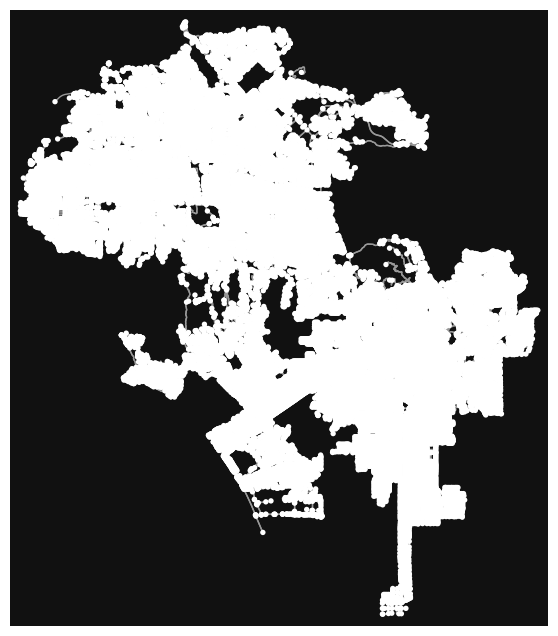

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [6]:
# Get the road network for California (or a city for better performance)
G = ox.graph_from_place("Los Angeles, California, USA", network_type="drive")

# Plot
ox.plot_graph(G)

In [15]:
import folium
from folium.plugins import HeatMap

# Sample 1000 accidents for performance
sample_df = df[['Start_Lat', 'Start_Lng']].dropna().sample(n=1000)

# Create base map
m = folium.Map(location=[34.05, -118.25], zoom_start=10)

# Add HeatMap layer
HeatMap(data=sample_df.values, radius=8).add_to(m)
m.save('accident_heatmap.html')


In [18]:
import networkx as nx
import osmnx as ox
from shapely.geometry import Point
from tqdm import tqdm

def get_nearest_edge(df, G, Use_Subset=False):
    if Use_Subset == True:
        df_subset = df.sample(n=15, random_state=42).copy()
        df = df_subset
        df = df
    else:
        df = df

    G = G.to_undirected()

    # Prepare KDTree for fast lookup of nearest edge
    nodes, edges = ox.graph_to_gdfs(G)

    # Create geometry column in accident data
    df['geometry'] = df.apply(lambda row: Point(row['Start_Lng'], row['Start_Lat']), axis=1)

    # Snap each accident to the nearest edge
    def get_nearest_edge(point):
        return ox.distance.nearest_edges(G, point.x, point.y)

    tqdm.pandas()
    df[['u', 'v', 'key']] = df['geometry'].progress_apply(lambda pt: pd.Series(get_nearest_edge(pt)))


    df.to_csv('data/la_accidents_with_edges.csv', index=False)
    df.to_parquet('data/la_accidents_with_edges.parquet')
    # Now each accident is mapped to an edge (u, v, key)

get_nearest_edge(df, G, Use_Subset=True)

100%|██████████| 15/15 [01:06<00:00,  4.44s/it]


ArrowInvalid: ('Could not convert <POINT (-118.281 33.988)> with type Point: did not recognize Python value type when inferring an Arrow data type', 'Conversion failed for column geometry with type object')